In [1]:
#pytorch
import torch #pytorch
import torchvision #pytorch datasets and vision functions
import torchvision.transforms as transforms
from torchvision.transforms import v2 #v2 transforms
import torch.optim as optim
import torch.nn as nn #neural network
from torch.utils.data import DataLoader #for val split

from tqdm.notebook import tqdm

#sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#images and plotting
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

#dataframes and arrays
import numpy as np

#GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using:', device)

Using: cuda


Load Data

In [2]:
transforms = v2.Compose([
    v2.Resize(size=(224,224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5, .5, .5], std=[0.5, .5, .5])
    ])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50000,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)



classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



# get some random training images
#dataiter = iter(trainloader)
#images, labels = next(dataiter)


Files already downloaded and verified
Files already downloaded and verified


Resnet-18

In [3]:
#from https://medium.com/analytics-vidhya/resnet-understand-and-implement-from-scratch-d0eb9725e0db
class ResNet18(nn.Module):
    def __init__(self, n_classes):
        super(ResNet18, self).__init__()
        
        self.dropout_percentage = 0.5
        self.relu = nn.ReLU()
        
        # BLOCK-1 (starting block) input=(224x224) output=(56x56)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(7,7), stride=(2,2), padding=(3,3))
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(1,1))
        
        # BLOCK-2 (1) input=(56x56) output = (56x56)
        self.conv2_1_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_1_1 = nn.BatchNorm2d(64)
        self.conv2_1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_1_2 = nn.BatchNorm2d(64)
        self.dropout2_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-2 (2)
        self.conv2_2_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_2_1 = nn.BatchNorm2d(64)
        self.conv2_2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_2_2 = nn.BatchNorm2d(64)
        self.dropout2_2 = nn.Dropout(p=self.dropout_percentage)
        
        # BLOCK-3 (1) input=(56x56) output = (28x28)
        self.conv3_1_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.batchnorm3_1_1 = nn.BatchNorm2d(128)
        self.conv3_1_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm3_1_2 = nn.BatchNorm2d(128)
        self.concat_adjust_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1,1), stride=(2,2), padding=(0,0))
        self.dropout3_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-3 (2)
        self.conv3_2_1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm3_2_1 = nn.BatchNorm2d(128)
        self.conv3_2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm3_2_2 = nn.BatchNorm2d(128)
        self.dropout3_2 = nn.Dropout(p=self.dropout_percentage)
        
        # BLOCK-4 (1) input=(28x28) output = (14x14)
        self.conv4_1_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.batchnorm4_1_1 = nn.BatchNorm2d(256)
        self.conv4_1_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm4_1_2 = nn.BatchNorm2d(256)
        self.concat_adjust_4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(1,1), stride=(2,2), padding=(0,0))
        self.dropout4_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-4 (2)
        self.conv4_2_1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm4_2_1 = nn.BatchNorm2d(256)
        self.conv4_2_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm4_2_2 = nn.BatchNorm2d(256)
        self.dropout4_2 = nn.Dropout(p=self.dropout_percentage)
        
        # BLOCK-5 (1) input=(14x14) output = (7x7)
        self.conv5_1_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.batchnorm5_1_1 = nn.BatchNorm2d(512)
        self.conv5_1_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm5_1_2 = nn.BatchNorm2d(512)
        self.concat_adjust_5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(1,1), stride=(2,2), padding=(0,0))
        self.dropout5_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-5 (2)
        self.conv5_2_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm5_2_1 = nn.BatchNorm2d(512)
        self.conv5_2_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm5_2_2 = nn.BatchNorm2d(512)
        self.dropout5_2 = nn.Dropout(p=self.dropout_percentage)
        
        # Final Block input=(7x7) 
        self.avgpool = nn.AvgPool2d(kernel_size=(7,7), stride=(1,1))
        self.fc = nn.Linear(in_features=1*1*512, out_features=1000)
        self.out = nn.Linear(in_features=1000, out_features=n_classes)
        # END
    
    def forward(self, x):
        
        # block 1 --> Starting block
        x = self.relu(self.batchnorm1(self.conv1(x)))
        op1 = self.maxpool1(x)
        
        
        # block2 - 1
        x = self.relu(self.batchnorm2_1_1(self.conv2_1_1(op1)))    # conv2_1 
        x = self.batchnorm2_1_2(self.conv2_1_2(x))                 # conv2_1
        x = self.dropout2_1(x)
        # block2 - Adjust - No adjust in this layer as dimensions are already same
        # block2 - Concatenate 1
        op2_1 = self.relu(x + op1)
        # block2 - 2
        x = self.relu(self.batchnorm2_2_1(self.conv2_2_1(op2_1)))  # conv2_2 
        x = self.batchnorm2_2_2(self.conv2_2_2(x))                 # conv2_2
        x = self.dropout2_2(x)
        # op - block2
        op2 = self.relu(x + op2_1)
    
        
        # block3 - 1[Convolution block]
        x = self.relu(self.batchnorm3_1_1(self.conv3_1_1(op2)))    # conv3_1
        x = self.batchnorm3_1_2(self.conv3_1_2(x))                 # conv3_1
        x = self.dropout3_1(x)
        # block3 - Adjust
        op2 = self.concat_adjust_3(op2) # SKIP CONNECTION
        # block3 - Concatenate 1
        op3_1 = self.relu(x + op2)
        # block3 - 2[Identity Block]
        x = self.relu(self.batchnorm3_2_1(self.conv3_2_1(op3_1)))  # conv3_2
        x = self.batchnorm3_2_2(self.conv3_2_2(x))                 # conv3_2 
        x = self.dropout3_2(x)
        # op - block3
        op3 = self.relu(x + op3_1)
        
        
        # block4 - 1[Convolition block]
        x = self.relu(self.batchnorm4_1_1(self.conv4_1_1(op3)))    # conv4_1
        x = self.batchnorm4_1_2(self.conv4_1_2(x))                 # conv4_1
        x = self.dropout4_1(x)
        # block4 - Adjust
        op3 = self.concat_adjust_4(op3) # SKIP CONNECTION
        # block4 - Concatenate 1
        op4_1 = self.relu(x + op3)
        # block4 - 2[Identity Block]
        x = self.relu(self.batchnorm4_2_1(self.conv4_2_1(op4_1)))  # conv4_2
        x = self.batchnorm4_2_2(self.conv4_2_2(x))                 # conv4_2
        x = self.dropout4_2(x)
        # op - block4
        op4 = self.relu(x + op4_1)

        
        # block5 - 1[Convolution Block]
        x = self.relu(self.batchnorm5_1_1(self.conv5_1_1(op4)))    # conv5_1
        x = self.batchnorm5_1_2(self.conv5_1_2(x))                 # conv5_1
        x = self.dropout5_1(x)
        # block5 - Adjust
        op4 = self.concat_adjust_5(op4) # SKIP CONNECTION
        # block5 - Concatenate 1
        op5_1 = self.relu(x + op4)
        # block5 - 2[Identity Block]
        x = self.relu(self.batchnorm5_2_1(self.conv5_2_1(op5_1)))  # conv5_2
        x = self.batchnorm5_2_1(self.conv5_2_1(x))                 # conv5_2
        x = self.dropout5_2(x)
        # op - block5
        op5 = self.relu(x + op5_1)


        # FINAL BLOCK - classifier 
        x = self.avgpool(op5)
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.fc(x))
        x = self.out(x)

        return x

In [4]:
#training from https://www.kaggle.com/code/modojj/resnet18-from-scratch-pytorch
# TESTING IF THE MODEL IS WORKING CORRECTLY
model1 = ResNet18(100).to(device)
data = torch.randn(64, 3, 224, 224).to(device)
print(model1(data).shape)

torch.Size([64, 100])


In [5]:
print(model1)

ResNet18(
  (relu): ReLU()
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
  (conv2_1_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2_1_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2_1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2_1): Dropout(p=0.5, inplace=False)
  (conv2_2_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2_2_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm2_2_2): BatchNo

In [6]:
train, val = torch.utils.data.random_split(trainset, [45000, 5000]) #45,000 training, 5000 validation
train_loader = DataLoader(dataset=train, batch_size=25, shuffle=True)
val_loader = DataLoader(dataset=val, batch_size=25, shuffle=True)

In [7]:
n_classes = len(set(trainset.targets)) #10 classes
n_batches = len(train_loader)

model = ResNet18(n_classes=n_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)


In [8]:

epochs = 100
train_accuracy_list=[]
val_accuracy_list=[]
#save best model
best_val_accuracy = 0.0  # Initialize the best validation accuracy
best_model_path = 'best_model.pth'  # Path to save the best model
for epoch in range(epochs):
    loss_list = []
    num_correct, num_samples = 0, 0
    for batch_num, (images, labels) in tqdm(enumerate(train_loader), total = n_batches):
        images = images.to(device)
        labels = labels.to(device)
        
        predictions = model(images)
        loss = criterion(predictions, labels)
        loss_list.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, train_predictions = predictions.max(1)
        num_correct += (train_predictions==labels).sum()
        num_samples += predictions.size(0)
    
    training_accuracy = float(num_correct)/float(num_samples)*100 
    train_accuracy_list.append(training_accuracy)
    
    
    val_loss_list = []
    val_num_correct, val_num_samples = 0, 0
    model.eval()
    with torch.no_grad():
        for val_batch_num, (val_images, val_labels) in enumerate(val_loader):
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            val_predictions = model(val_images)
            _, val_preds = val_predictions.max(1)
            
            val_num_correct += (val_preds==val_labels).sum()
            val_num_samples += val_preds.size(0)
            
            val_loss_list.append(criterion(val_predictions, val_labels))
            
            best_accuracy = 0
            best_accuracy += (val_preds == val_labels).sum().item()
        best_accuracy /= len(val_loader.dataset)
    if best_accuracy > best_val_accuracy:
        best_val_accuracy = best_accuracy
        torch.save(model.state_dict(), best_model_path)


        
    val_accuracy = float(val_num_correct)/float(val_num_samples)*100
    val_accuracy_list.append(val_accuracy)
    model.train()

    print(f'Epoch: {epoch + 1} | Accuracy: {training_accuracy:.2f} | loss: {sum(loss_list)/len(loss_list)}', end='')
    print(f' | Validation Accuracy: {val_accuracy:.2f} | Validation loss: {sum(val_loss_list)/len(val_loss_list)}')


model.load_state_dict(torch.load(best_model_path))


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 1 | Accuracy: 32.87 | loss: 1.7941814661026 | Validation Accuracy: 22.02 | Validation loss: 2.5092663764953613


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 2 | Accuracy: 46.75 | loss: 1.4522267580032349 | Validation Accuracy: 33.74 | Validation loss: 2.1516201496124268


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 3 | Accuracy: 52.90 | loss: 1.2987877130508423 | Validation Accuracy: 37.12 | Validation loss: 1.9907937049865723


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 4 | Accuracy: 57.09 | loss: 1.1867084503173828 | Validation Accuracy: 42.94 | Validation loss: 1.771574854850769


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 5 | Accuracy: 60.28 | loss: 1.103094220161438 | Validation Accuracy: 44.68 | Validation loss: 1.6981531381607056


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 6 | Accuracy: 63.02 | loss: 1.034886360168457 | Validation Accuracy: 46.52 | Validation loss: 1.60023832321167


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 7 | Accuracy: 65.04 | loss: 0.9822891354560852 | Validation Accuracy: 53.06 | Validation loss: 1.4166022539138794


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 8 | Accuracy: 66.68 | loss: 0.932723343372345 | Validation Accuracy: 61.72 | Validation loss: 1.1155354976654053


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 9 | Accuracy: 68.46 | loss: 0.8877348899841309 | Validation Accuracy: 62.62 | Validation loss: 1.0951963663101196


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 10 | Accuracy: 70.23 | loss: 0.8479912281036377 | Validation Accuracy: 68.54 | Validation loss: 0.9065862894058228


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 11 | Accuracy: 71.40 | loss: 0.812312126159668 | Validation Accuracy: 68.74 | Validation loss: 0.9094732403755188


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 12 | Accuracy: 72.83 | loss: 0.7711806893348694 | Validation Accuracy: 71.52 | Validation loss: 0.8166329860687256


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 13 | Accuracy: 74.27 | loss: 0.7342426180839539 | Validation Accuracy: 73.64 | Validation loss: 0.7527728080749512


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 14 | Accuracy: 75.48 | loss: 0.7009764313697815 | Validation Accuracy: 72.52 | Validation loss: 0.7801949977874756


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 15 | Accuracy: 76.57 | loss: 0.6666934490203857 | Validation Accuracy: 74.08 | Validation loss: 0.7530360817909241


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 16 | Accuracy: 77.93 | loss: 0.6326240301132202 | Validation Accuracy: 76.32 | Validation loss: 0.684734582901001


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 17 | Accuracy: 78.89 | loss: 0.6112382411956787 | Validation Accuracy: 77.46 | Validation loss: 0.6434805393218994


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 18 | Accuracy: 79.63 | loss: 0.5898817181587219 | Validation Accuracy: 77.60 | Validation loss: 0.6446830630302429


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 19 | Accuracy: 80.24 | loss: 0.5672736167907715 | Validation Accuracy: 77.98 | Validation loss: 0.6288937330245972


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 20 | Accuracy: 80.85 | loss: 0.5480096340179443 | Validation Accuracy: 78.68 | Validation loss: 0.6117318868637085


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 21 | Accuracy: 81.94 | loss: 0.5259021520614624 | Validation Accuracy: 79.42 | Validation loss: 0.58709716796875


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 22 | Accuracy: 82.21 | loss: 0.5061726570129395 | Validation Accuracy: 78.48 | Validation loss: 0.6127391457557678


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 23 | Accuracy: 82.80 | loss: 0.491649329662323 | Validation Accuracy: 80.72 | Validation loss: 0.5495196580886841


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 24 | Accuracy: 83.55 | loss: 0.47301185131073 | Validation Accuracy: 78.78 | Validation loss: 0.6231423616409302


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 25 | Accuracy: 83.84 | loss: 0.4636152982711792 | Validation Accuracy: 81.40 | Validation loss: 0.5397592186927795


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 26 | Accuracy: 84.52 | loss: 0.4444155693054199 | Validation Accuracy: 81.80 | Validation loss: 0.5174534916877747


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 27 | Accuracy: 85.09 | loss: 0.4281531870365143 | Validation Accuracy: 81.84 | Validation loss: 0.5204557180404663


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 28 | Accuracy: 85.65 | loss: 0.41401708126068115 | Validation Accuracy: 80.94 | Validation loss: 0.555884063243866


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 29 | Accuracy: 85.86 | loss: 0.4048515856266022 | Validation Accuracy: 83.10 | Validation loss: 0.49181437492370605


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 30 | Accuracy: 86.38 | loss: 0.3919036090373993 | Validation Accuracy: 82.10 | Validation loss: 0.530609667301178


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 31 | Accuracy: 86.80 | loss: 0.37731340527534485 | Validation Accuracy: 83.04 | Validation loss: 0.491108775138855


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 32 | Accuracy: 87.35 | loss: 0.3638434410095215 | Validation Accuracy: 82.78 | Validation loss: 0.5091845989227295


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 33 | Accuracy: 87.72 | loss: 0.3535994589328766 | Validation Accuracy: 83.52 | Validation loss: 0.47126081585884094


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 34 | Accuracy: 88.02 | loss: 0.3427134156227112 | Validation Accuracy: 83.20 | Validation loss: 0.4967326521873474


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 35 | Accuracy: 88.47 | loss: 0.33062389492988586 | Validation Accuracy: 82.88 | Validation loss: 0.521159291267395


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 36 | Accuracy: 88.85 | loss: 0.3217063248157501 | Validation Accuracy: 82.80 | Validation loss: 0.5114263296127319


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 37 | Accuracy: 89.28 | loss: 0.3063288927078247 | Validation Accuracy: 84.48 | Validation loss: 0.45697274804115295


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 38 | Accuracy: 89.51 | loss: 0.3007180988788605 | Validation Accuracy: 82.76 | Validation loss: 0.5183241963386536


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 39 | Accuracy: 89.58 | loss: 0.2927449941635132 | Validation Accuracy: 83.08 | Validation loss: 0.5078046321868896


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 40 | Accuracy: 90.06 | loss: 0.2815453112125397 | Validation Accuracy: 84.48 | Validation loss: 0.4533403217792511


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 41 | Accuracy: 90.46 | loss: 0.2701805531978607 | Validation Accuracy: 84.02 | Validation loss: 0.4837704598903656


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 42 | Accuracy: 90.90 | loss: 0.25826042890548706 | Validation Accuracy: 83.66 | Validation loss: 0.5265569090843201


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 43 | Accuracy: 91.14 | loss: 0.25173109769821167 | Validation Accuracy: 83.52 | Validation loss: 0.5146024227142334


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 44 | Accuracy: 91.24 | loss: 0.24629130959510803 | Validation Accuracy: 83.90 | Validation loss: 0.5053616762161255


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 45 | Accuracy: 91.70 | loss: 0.2351696640253067 | Validation Accuracy: 84.30 | Validation loss: 0.4708476960659027


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 46 | Accuracy: 92.18 | loss: 0.22447322309017181 | Validation Accuracy: 83.28 | Validation loss: 0.5184073448181152


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 47 | Accuracy: 92.06 | loss: 0.2239844650030136 | Validation Accuracy: 84.82 | Validation loss: 0.46346014738082886


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 48 | Accuracy: 92.34 | loss: 0.21471159160137177 | Validation Accuracy: 85.38 | Validation loss: 0.4511272609233856


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 49 | Accuracy: 92.73 | loss: 0.2053307145833969 | Validation Accuracy: 85.08 | Validation loss: 0.4606373608112335


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 50 | Accuracy: 92.97 | loss: 0.1962231546640396 | Validation Accuracy: 85.36 | Validation loss: 0.49112555384635925


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 51 | Accuracy: 93.15 | loss: 0.19295449554920197 | Validation Accuracy: 84.94 | Validation loss: 0.47997912764549255


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 52 | Accuracy: 93.33 | loss: 0.18627461791038513 | Validation Accuracy: 85.26 | Validation loss: 0.4805223047733307


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 53 | Accuracy: 93.85 | loss: 0.17557178437709808 | Validation Accuracy: 84.80 | Validation loss: 0.49444830417633057


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 54 | Accuracy: 94.12 | loss: 0.16604073345661163 | Validation Accuracy: 84.86 | Validation loss: 0.49355238676071167


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 55 | Accuracy: 93.87 | loss: 0.1710464060306549 | Validation Accuracy: 85.50 | Validation loss: 0.4745749235153198


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 56 | Accuracy: 94.32 | loss: 0.15904806554317474 | Validation Accuracy: 84.46 | Validation loss: 0.5121594071388245


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 57 | Accuracy: 94.31 | loss: 0.15755905210971832 | Validation Accuracy: 85.48 | Validation loss: 0.48554766178131104


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 58 | Accuracy: 94.78 | loss: 0.14879043400287628 | Validation Accuracy: 84.38 | Validation loss: 0.53055739402771


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 59 | Accuracy: 94.69 | loss: 0.14918063580989838 | Validation Accuracy: 85.38 | Validation loss: 0.5043172240257263


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 60 | Accuracy: 94.96 | loss: 0.14125829935073853 | Validation Accuracy: 85.08 | Validation loss: 0.5092408061027527


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 61 | Accuracy: 95.29 | loss: 0.1356961578130722 | Validation Accuracy: 85.52 | Validation loss: 0.4948604106903076


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 62 | Accuracy: 95.40 | loss: 0.13008548319339752 | Validation Accuracy: 84.80 | Validation loss: 0.5228736996650696


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 63 | Accuracy: 95.51 | loss: 0.12766067683696747 | Validation Accuracy: 85.26 | Validation loss: 0.5144986510276794


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 64 | Accuracy: 95.48 | loss: 0.12570489943027496 | Validation Accuracy: 85.36 | Validation loss: 0.5069006085395813


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 65 | Accuracy: 95.93 | loss: 0.11528442800045013 | Validation Accuracy: 84.80 | Validation loss: 0.5531138777732849


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 66 | Accuracy: 95.80 | loss: 0.11797633767127991 | Validation Accuracy: 85.24 | Validation loss: 0.5319142937660217


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 67 | Accuracy: 96.02 | loss: 0.11304960399866104 | Validation Accuracy: 85.32 | Validation loss: 0.5176971554756165


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 68 | Accuracy: 96.32 | loss: 0.10681862384080887 | Validation Accuracy: 85.98 | Validation loss: 0.4897918999195099


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 69 | Accuracy: 96.07 | loss: 0.10898100584745407 | Validation Accuracy: 85.32 | Validation loss: 0.5321194529533386


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 70 | Accuracy: 96.47 | loss: 0.10089775919914246 | Validation Accuracy: 85.90 | Validation loss: 0.5137649774551392


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 71 | Accuracy: 96.54 | loss: 0.0984978899359703 | Validation Accuracy: 84.66 | Validation loss: 0.5711905360221863


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 72 | Accuracy: 96.49 | loss: 0.09917199611663818 | Validation Accuracy: 86.42 | Validation loss: 0.4942757785320282


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 73 | Accuracy: 96.70 | loss: 0.09411212056875229 | Validation Accuracy: 84.94 | Validation loss: 0.562957227230072


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 74 | Accuracy: 96.78 | loss: 0.09085764735937119 | Validation Accuracy: 85.24 | Validation loss: 0.5708089470863342


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 75 | Accuracy: 96.96 | loss: 0.08922011405229568 | Validation Accuracy: 85.76 | Validation loss: 0.5316985249519348


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 76 | Accuracy: 96.98 | loss: 0.08766793459653854 | Validation Accuracy: 85.42 | Validation loss: 0.5419635772705078


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 77 | Accuracy: 97.07 | loss: 0.08350113779306412 | Validation Accuracy: 86.28 | Validation loss: 0.5118054747581482


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 78 | Accuracy: 97.08 | loss: 0.0841599702835083 | Validation Accuracy: 85.42 | Validation loss: 0.5514756441116333


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 79 | Accuracy: 97.17 | loss: 0.07985056936740875 | Validation Accuracy: 86.64 | Validation loss: 0.5044348239898682


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 80 | Accuracy: 97.23 | loss: 0.0779092088341713 | Validation Accuracy: 85.76 | Validation loss: 0.5561824440956116


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 81 | Accuracy: 97.28 | loss: 0.07731570303440094 | Validation Accuracy: 85.66 | Validation loss: 0.5498346090316772


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 82 | Accuracy: 97.38 | loss: 0.0738244280219078 | Validation Accuracy: 85.14 | Validation loss: 0.5924621820449829


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 83 | Accuracy: 97.36 | loss: 0.07455071806907654 | Validation Accuracy: 85.98 | Validation loss: 0.5467916131019592


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 84 | Accuracy: 97.57 | loss: 0.0700773224234581 | Validation Accuracy: 86.40 | Validation loss: 0.5225475430488586


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 85 | Accuracy: 97.66 | loss: 0.06959627568721771 | Validation Accuracy: 86.66 | Validation loss: 0.516089677810669


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 86 | Accuracy: 97.64 | loss: 0.06834433227777481 | Validation Accuracy: 86.88 | Validation loss: 0.5185950994491577


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 87 | Accuracy: 97.69 | loss: 0.06494614481925964 | Validation Accuracy: 86.14 | Validation loss: 0.5327902436256409


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 88 | Accuracy: 97.82 | loss: 0.06359658390283585 | Validation Accuracy: 86.66 | Validation loss: 0.52490234375


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 89 | Accuracy: 97.94 | loss: 0.06091765686869621 | Validation Accuracy: 86.26 | Validation loss: 0.5500640273094177


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 90 | Accuracy: 97.86 | loss: 0.06172031909227371 | Validation Accuracy: 85.54 | Validation loss: 0.5697410702705383


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 91 | Accuracy: 97.76 | loss: 0.06280910223722458 | Validation Accuracy: 85.58 | Validation loss: 0.5989364385604858


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 92 | Accuracy: 98.00 | loss: 0.058729156851768494 | Validation Accuracy: 86.58 | Validation loss: 0.5535881519317627


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 93 | Accuracy: 97.94 | loss: 0.059017281979322433 | Validation Accuracy: 86.00 | Validation loss: 0.5537943243980408


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 94 | Accuracy: 97.99 | loss: 0.05822873115539551 | Validation Accuracy: 86.84 | Validation loss: 0.5252825617790222


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 95 | Accuracy: 98.11 | loss: 0.05440284311771393 | Validation Accuracy: 85.68 | Validation loss: 0.5714206099510193


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 96 | Accuracy: 98.10 | loss: 0.05582039803266525 | Validation Accuracy: 87.34 | Validation loss: 0.531933605670929


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 97 | Accuracy: 98.25 | loss: 0.05046527460217476 | Validation Accuracy: 85.88 | Validation loss: 0.5760632157325745


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 98 | Accuracy: 98.26 | loss: 0.05140075460076332 | Validation Accuracy: 87.14 | Validation loss: 0.5433701872825623


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 99 | Accuracy: 98.18 | loss: 0.05333496630191803 | Validation Accuracy: 86.12 | Validation loss: 0.5527250170707703


  0%|          | 0/1800 [00:00<?, ?it/s]

Epoch: 100 | Accuracy: 98.33 | loss: 0.04894495755434036 | Validation Accuracy: 86.06 | Validation loss: 0.5597660541534424


<All keys matched successfully>

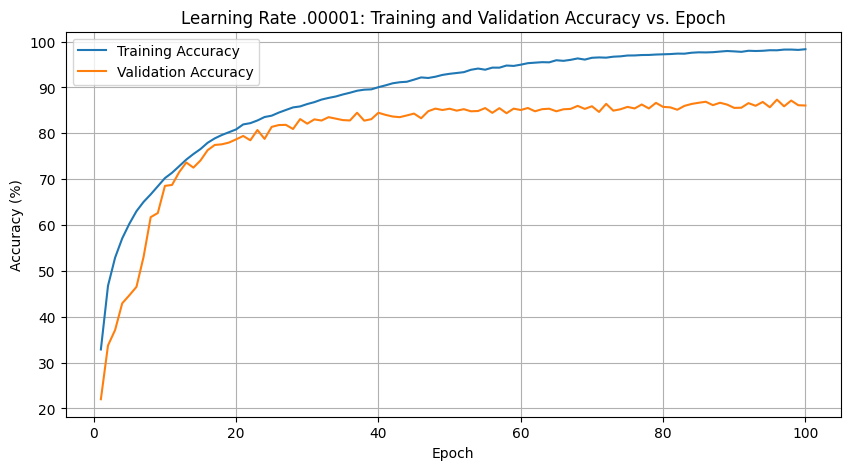

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_accuracy_list, label='Training Accuracy')
plt.plot(range(1, epochs+1), val_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Learning Rate .00001: Training and Validation Accuracy vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
best_model_path = 'best_model.pth'  # Path to save the best model
 
model.load_state_dict(torch.load(best_model_path))

test_loss_list = []
test_num_correct, test_num_samples = 0, 0
model.eval()
test_preds_all = []
test_labels_all = []
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
with torch.no_grad():
    for test_batch_num, (test_images, test_labels) in enumerate(testloader):
        test_images = test_images.to(device)
        test_labels = test_labels.to(device)

        test_predictions = model(test_images)
        _, test_preds = test_predictions.max(1)
        
        test_preds_all.extend(test_preds.cpu().numpy())
        test_labels_all.extend(test_labels.cpu().numpy())

        test_num_correct += (test_preds == test_labels).sum().item()
        test_num_samples += test_preds.size(0)

        test_loss_list.append(criterion(test_predictions, test_labels))

        for label, prediction in zip(test_labels, test_preds):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

test_accuracy = accuracy_score(test_labels_all, test_preds_all)
test_precision = precision_score(test_labels_all, test_preds_all, average='macro')
test_recall = recall_score(test_labels_all, test_preds_all, average='macro')
test_f1_score = f1_score(test_labels_all, test_preds_all, average='macro')
test_conf_matrix = confusion_matrix(test_labels_all, test_preds_all)

print(f'Test Accuracy: {test_accuracy*100:.2f}%')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1_score:.4f}')
print('Confusion Matrix:')

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Test Accuracy: 84.67%
Test Precision: 0.8552
Test Recall: 0.8467
Test F1 Score: 0.8454
Confusion Matrix:
Accuracy for class: plane is 77.1 %
Accuracy for class: car   is 91.0 %
Accuracy for class: bird  is 83.8 %
Accuracy for class: cat   is 77.9 %
Accuracy for class: deer  is 78.2 %
Accuracy for class: dog   is 64.0 %
Accuracy for class: frog  is 89.9 %
Accuracy for class: horse is 93.7 %
Accuracy for class: ship  is 95.7 %
Accuracy for class: truck is 95.4 %


In [10]:
print(f' | Testing Accuracy: {test_accuracy:.2f} | test loss: {sum(test_loss_list)/len(test_loss_list)}')

 | Testing Accuracy: 0.85 | test loss: 0.550906777381897


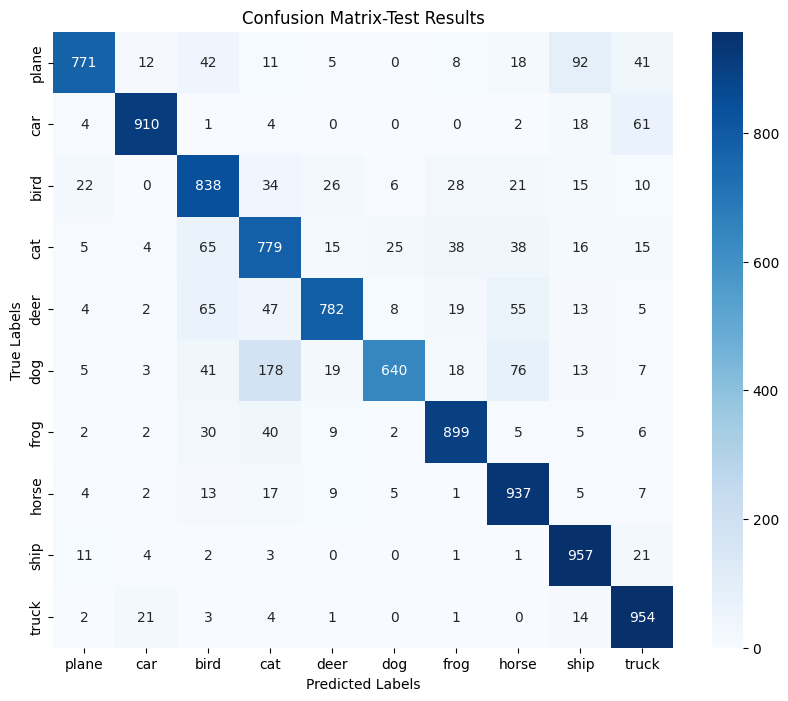

In [11]:
# Plot confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix-Test Results')
plt.show()


In [12]:
from functools import partial

activation_layers = {}  # Dictionary to store intermediate activations

def hook_fn(module, input, output, layer_name):
    activation_layers[layer_name] = output.detach()

# Register hooks to capture intermediate layer activations
for name, layer in model.named_modules():
    if isinstance(layer, torch.nn.Conv2d):
        layer.register_forward_hook(partial(hook_fn, layer_name=name))

# Inside your testing loop
for test_batch_num, (test_images, test_labels) in enumerate(testloader):
    test_images = test_images.to(device)
    test_labels = test_labels.to(device)

    test_predictions = model(test_images)

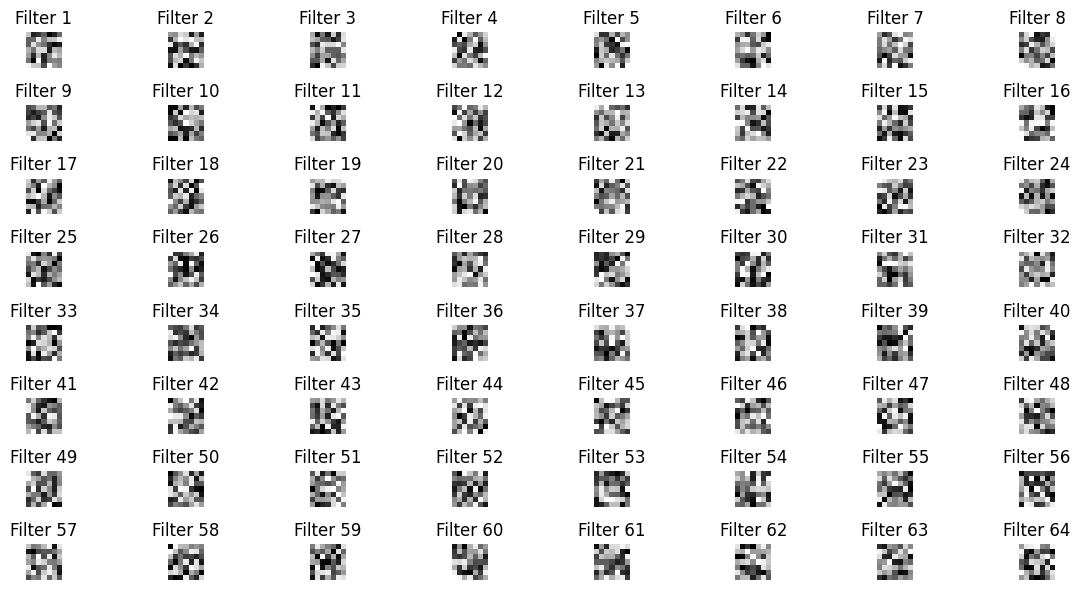

In [24]:
# Assuming you have a trained model instance named 'model'
# Extract filter weights from conv1 layer
filters_conv1 = model.conv1.weight.data.cpu().numpy()
num_filters_conv1 = filters_conv1.shape[0]  # Number of filters in conv1

# Visualize filters in conv1
fig, axs = plt.subplots(8, num_filters_conv1 // 8, figsize=(12, 6))
axs = axs.flatten()

for i in range(num_filters_conv1):
    filter_weights = filters_conv1[i, 0]  # Assuming single-channel filters
    axs[i].imshow(filter_weights, cmap='gray')  # Grayscale plot
    axs[i].axis('off')
    axs[i].set_title(f'Filter {i+1}')

plt.tight_layout()
plt.show()